[![image-1.png](https://i.postimg.cc/Dw0ChHKk/image-1.png)](https://postimg.cc/LJdkByXN)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:30px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Определение музыкального жанра</p>


</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Музыкальный стриминговый сервис "МиФаСоль"
    
__Описание задачи:__ Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы.

__Постановка задачи:__ Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.
    
__Описание данных:__
    
- файл `train.csv` информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
    
- файл `test.csv` информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных.
    
__Описание полей данных:__
    
- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность
- danceability - танцевальность
- duration_ms -продолжительность в милисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key - базовый ключ (нота) произведения
- liveness - привлекательность
- loudness - громкость
- mode - указывает на модальность (мажорную или минорную) трека
- speechiness - выразительность
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - привлекательность произведения для пользователей сервиса
- __music_genre__ - музыкальный жанр (целевой признак)

__Оценка результата:__ в данной задаче мы будем использовать метрику f1_micro для оценки качества модели.
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [98]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score, classification_report

from sklearn.linear_model import LinearRegression

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold
import optuna

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv

import transformers
from tqdm import notebook, tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping

# константы
RANDOM_SEED = 42

# настройки блокнота
random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка и общая информация данных

</div>

In [2]:
# загрузка информации для обучения:
try:
    train = pd.read_csv('data/train.csv')
    print('Информация для обучения:')
    display(train.head(2))
    display(train.info())
except:
    print('Информация для обучения не доступна')
    
# загрузка информации для тестирования:
try:
    test = pd.read_csv('data/test.csv')
    print('Информация для тестирования:')
    display(test.head(2))
    display(test.info())
except:
    print('Информация для тестирования не доступна')

Информация для обучения:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.480,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.243,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

None

Информация для тестирования:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


None

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Анализ данных

</div>

- `obtained_date`: дата загрузки в сервис, не может влиять на жанр, удаляем этот признак.
- `valence`: привлекательность произведения для пользователей сервиса, так же является субективной мерой, исключаем из дальнейшего анализа,
- `instance_id`: уникальный идентификатор трека, после проверки на уникальность, и преобразования в цельночисленный формат будут переведены в индекс.

In [3]:
# удаляем столбцы 'obtained_date' и 'valence' из обучающего и тестового наборов данных
train = train.drop(['obtained_date', 'valence'], axis=1)
test = test.drop(['obtained_date', 'valence'], axis=1)

__Проверим дубликатов в данных:__

In [4]:
print(f'Общее количество дубликатов в данных: {sum(df.duplicated().sum() for df in [train, test])}')

Общее количество дубликатов в данных: 0


__Проверим уникальность значений признака `instance_id`__

In [5]:
if all(len(df['instance_id'].unique()) == len(df) for df in [train, test]):
    print('Признак instance_id содержит уникальные значения в обоих датасетах')
else: print('Признак instance_id содержит дублирующиеся значения')

Признак instance_id содержит уникальные значения в обоих датасетах


In [6]:
# преобразуем тип данных столбца 'instance_id' в целочисленный
train['instance_id'] = train['instance_id'].astype(int)
test['instance_id'] = test['instance_id'].astype(int)
# устанавливаем признак 'instance_id' в качестве индекса для обучающего и тестового наборов данных
train.set_index('instance_id', inplace=True)
test.set_index('instance_id', inplace=True)

>- Исключены из анализа признаки `obtained_date` и `valence`
>- Признак `instance_id` установлен в качестве индекса

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Анализ числовых признаков

</div>

In [7]:
# общая информация
train.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


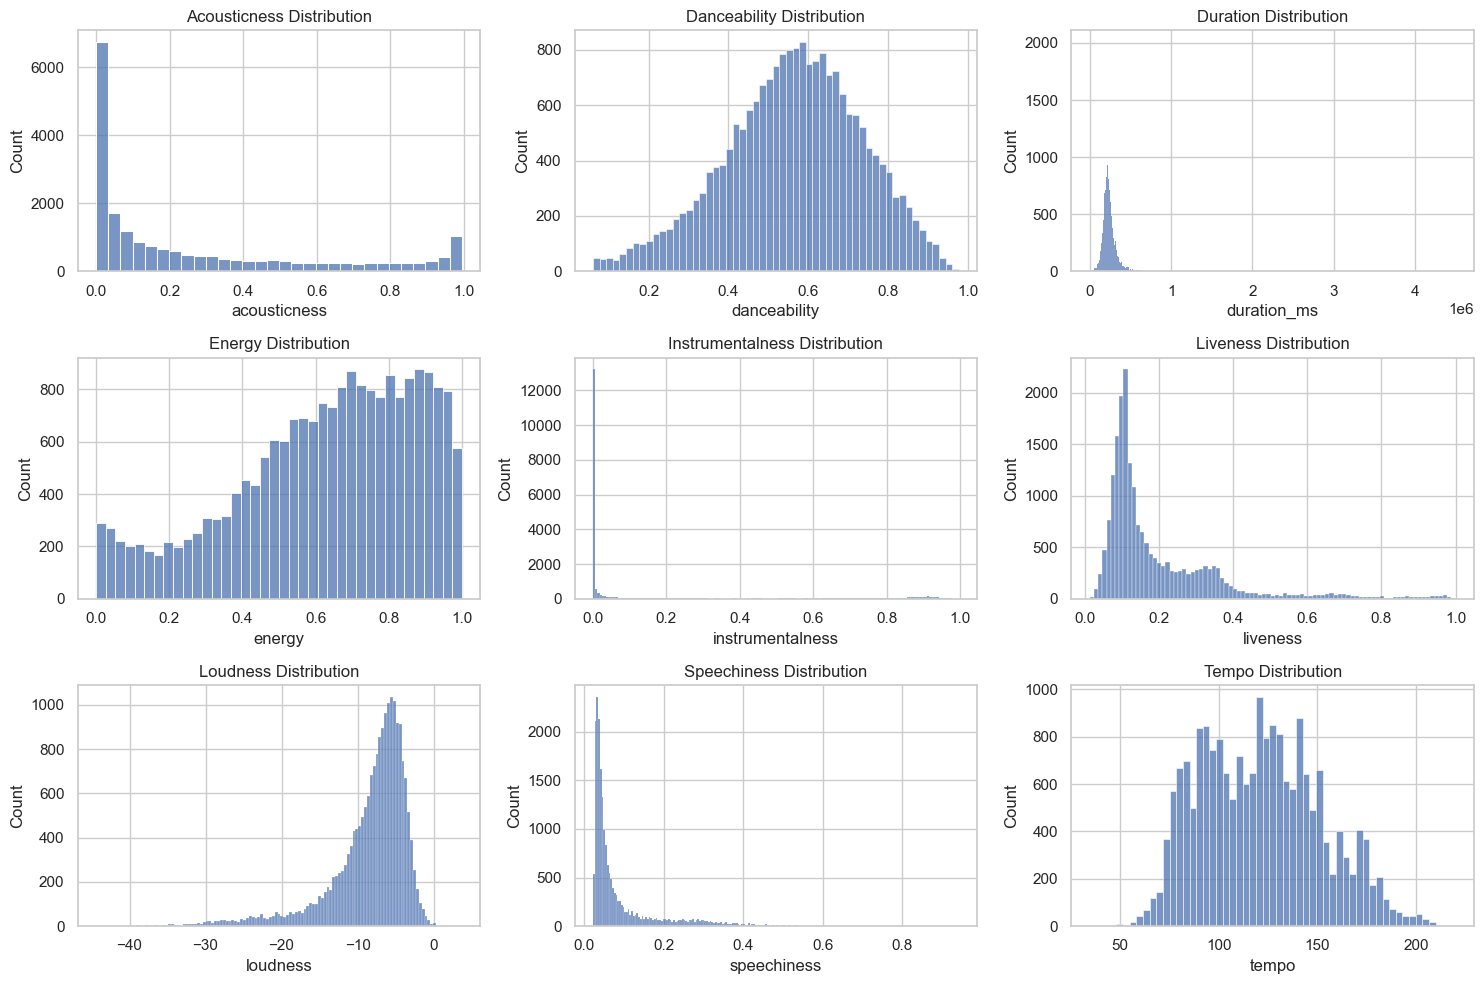

In [8]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# гистограмма для 'acousticness'
sns.histplot(train['acousticness'], ax=axes[0, 0])
axes[0, 0].set_title('Acousticness Distribution')

# гистограмма для для 'danceability'
sns.histplot(train['danceability'], ax=axes[0, 1])
axes[0, 1].set_title('Danceability Distribution')

# гистограмма для для 'duration_ms'
sns.histplot(train['duration_ms'], ax=axes[0, 2])
axes[0, 2].set_title('Duration Distribution')

# гистограмма для для 'energy'
sns.histplot(train['energy'], ax=axes[1, 0])
axes[1, 0].set_title('Energy Distribution')

# гистограмма для для 'instrumentalness'
sns.histplot(train['instrumentalness'], ax=axes[1, 1])
axes[1, 1].set_title('Instrumentalness Distribution')

# гистограмма для для 'liveness'
sns.histplot(train['liveness'], ax=axes[1, 2])
axes[1, 2].set_title('Liveness Distribution')

# гистограмма для для 'loudness'
sns.histplot(train['loudness'], ax=axes[2, 0])
axes[2, 0].set_title('Loudness Distribution')

# гистограмма для для 'speechiness'
sns.histplot(train['speechiness'], ax=axes[2, 1])
axes[2, 1].set_title('Speechiness Distribution')

# гистограмма для для 'tempo'
sns.histplot(train['tempo'], ax=axes[2, 2])
axes[2, 2].set_title('Tempo Distribution')

# графики
plt.tight_layout()
plt.show()


### duration_ms: продолжительность в милисекундах

В данных присутствуют отрицательные значения и крайне длинные треки:

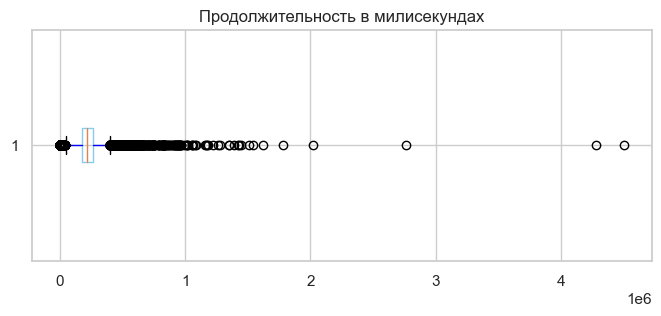

In [9]:
# boxplot для признака vehicle_age
plt.figure(figsize=(8,3))
plt.boxplot(train['duration_ms'], vert=False, boxprops=dict(color='skyblue'), whiskerprops=dict(color='blue'))
plt.grid(True)
plt.title('Продолжительность в милисекундах')
plt.show()

In [10]:
# рассчет верхнего порога аномальных значений
q1 = train['duration_ms'].quantile(0.25)
q3 = train['duration_ms'].quantile(0.75)
upper_threshold = int(q3+3*(q3-q1))
print(f'Порог аномальных значений: {upper_threshold} милисекунд')
# рассчитываем нижний порог для аномальных значений
lower_threshold = q1 - 2*(q3 - q1)
print(f'Нижний порог аномальных значений: {int(lower_threshold)} миллисекунд')

Порог аномальных значений: 531449 милисекунд
Нижний порог аномальных значений: 551 миллисекунд


__Обработка аномальных значений__

In [13]:
# заменяем значения ниже нижнего порога
train['duration_ms'] = np.where(train['duration_ms'] < lower_threshold, train['duration_ms'].median(), train['duration_ms'])
# заменяем значения выше верхнего порога
train['duration_ms'] = np.where(train['duration_ms'] > upper_threshold, train['duration_ms'].median(), train['duration_ms'])

# заменяем значения ниже нижнего порога
test['duration_ms'] = np.where(test['duration_ms'] < lower_threshold, test['duration_ms'].median(), test['duration_ms'])
# заменяем значения выше верхнего порога
test['duration_ms'] = np.where(test['duration_ms'] > upper_threshold, test['duration_ms'].median(), test['duration_ms'])

__Преобразуем тип данных столбца 'duration_ms' в целочисленный__

In [14]:
train['duration_ms'] = train['duration_ms'].astype(int)
test['duration_ms'] = test['duration_ms'].astype(int)

>Все остальные числовые данные, включая "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", и "speechiness", "tempo", укладываются в пределы допустимых значений и варьируются в рамках нормальных диапазонов для соответствующих музыкальных характеристик. Нет никаких явных аномалий в этих признаках, и они соответствуют типичным значениям для музыкальных данных.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Анализ категориальные признаков

</div>

__Проверим уникальные значения в категориальных признаках__

In [15]:
# общая информация 
display(train.describe(include=[object]).T)

,count,unique,top,freq
track_name,20394,18643,Home,11
key,19659,12,G,2304
mode,19888,2,Major,12828
music_genre,20394,10,Blues,2858


__Уникальные значения признака `key`__

In [16]:
train['key'].unique()

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#',
       'B'], dtype=object)

>Эти значения представляют собой ноты или аккорды, которые могут быть частью музыкальных произведений. Они соответствуют музыкальным элементам и могут использоваться для определения характера и мелодических особенностей треков.

### Баланс целевой переменной

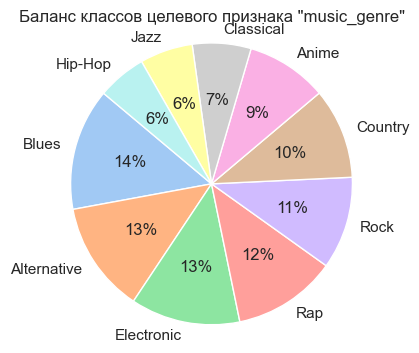

In [17]:
# количество каждого класса
data = train['music_genre'].value_counts()

# метоки классов
labels = data.index
sizes = data.values
colors = sns.color_palette('pastel')

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=140)
plt.title('Баланс классов целевого признака "music_genre"')
plt.axis('equal')

# отображение диаграммы
plt.show()

>Баланс классов для целевого признака "music_genre" в тренировочных данных не показывает сильного дисбаланса. Визуализация круговой диаграммы показывает, что классы достаточно равномерно представлены в данных, что является положительным для задачи классификации. Нет явного доминирования одного класса над другим, что упрощает обучение модели и ее способность делать предсказания для разных жанров музыки.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Пропуски в данных

</div>

In [18]:
# функция для рассчето количества пропусков
def isna_sum(df):
    print('Признаки содержащие пропуски:')
    for col in df.columns:
        if df[col].isna().sum()>0:
            print(f'{col}: {df[col].isna().mean():.2%}')

In [19]:
# пропуски в данных для обучения
isna_sum(train)

Признаки содержащие пропуски:
key: 3.60%
mode: 2.48%
tempo: 2.17%


In [20]:
# пропуски в данных для тестирования
isna_sum(test)

Признаки содержащие пропуски:
key: 3.10%
mode: 2.92%
tempo: 2.37%


>Пропуски в данных присутствуют как в тренировочном, так и тестовом наборе данных.
>С учетом того, что удалить данные из тестового набора данных в данной задаче нельзя, попробуем выработать стратегию по заполнению пропусков:
>- создадим копию тренировочного датасета
>- удалим пропуски
>- проверим взаимосвязь признаков

In [21]:
# копия датасета без пропусков
df = train.dropna()

print(f'Общее количество пропусков в данных: {sum(df.isna().sum())}')

Общее количество пропусков в данных: 0


### Корреляции между признаками

Метод PHIK - это статистический метод для определения взаимосвязей между категориальными переменными. Он разработан на основе корреляционного анализа, но специально адаптирован для работы с категориальными данными, которые обычно представлены в виде таблиц сопряженности.

In [22]:
phik_overview = df[[col for col in df.columns if col != 'track_name']].phik_matrix()
display(phik_overview)

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,music_genre
acousticness,1.000000,0.458387,0.227117,0.766578,0.442590,0.096909,0.188614,0.710162,0.026286,0.207558,0.335410,0.658403
danceability,0.458387,1.000000,0.215398,0.515209,0.339896,0.103118,0.132911,0.480074,0.100629,0.336219,0.407936,0.623712
duration_ms,0.227117,0.215398,1.000000,0.241151,0.300145,0.023230,0.118015,0.293464,0.040955,0.184906,0.102494,0.341913
energy,0.766578,0.515209,0.241151,1.000000,0.438574,0.090880,0.260662,0.838452,0.033019,0.239170,0.388336,0.671806
instrumentalness,0.442590,0.339896,0.300145,0.438574,1.000000,0.029922,0.138975,0.498535,0.087474,0.190471,0.217914,0.568069
key,0.096909,0.103118,0.023230,0.090880,0.029922,1.000000,0.057933,0.080208,0.357610,0.117888,0.039206,0.170758
liveness,0.188614,0.132911,0.118015,0.260662,0.138975,0.057933,1.000000,0.202501,0.031851,0.140039,0.082196,0.207030
loudness,0.710162,0.480074,0.293464,0.838452,0.498535,0.080208,0.202501,1.000000,0.019127,0.208318,0.357106,0.679765
mode,0.026286,0.100629,0.040955,0.033019,0.087474,0.357610,0.031851,0.019127,1.000000,0.107284,0.008667,0.295554
speechiness,0.207558,0.336219,0.184906,0.239170,0.190471,0.117888,0.140039,0.208318,0.107284,1.000000,0.185911,0.497169


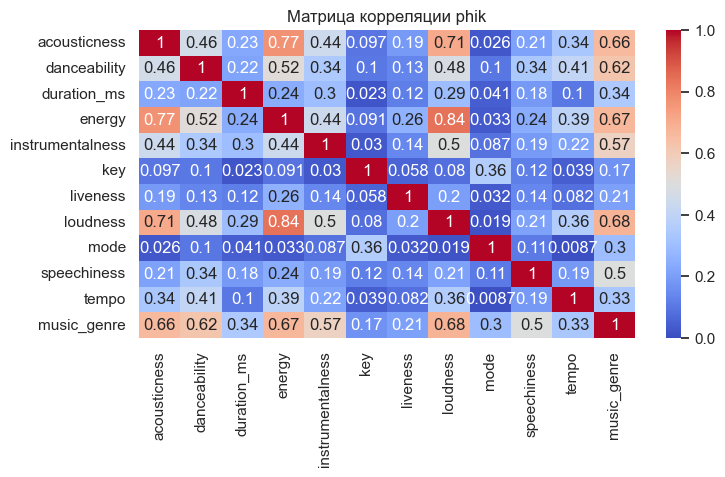

In [23]:
# heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

>Существует сильная кореляция между признаками energy и loudness, что может указывать на мультиколинеарность, в процессе разработки линейных моделей, возможно исключение признака energy, тк данный признак менее связан с целевым.

### Пропуски в данных признака `tempo`

Попробуем построить модель LinearRegression для предсказания данного признака на основе данных и наибольшей кореляцией

In [24]:
tempo_df = df[['acousticness', 'danceability', 'energy', 'loudness', 'tempo']]

In [25]:
display(tempo_df.head(2))

,acousticness,danceability,energy,loudness,tempo
instance_id,,,,,
25143,0.480,0.670,0.351,-16.842,101.384
26091,0.243,0.452,0.670,-8.392,113.071


In [26]:
# выбор признаков и целевой переменной
X = tempo_df.drop('tempo', axis=1)
y = tempo_df['tempo']

# разделение данных на тренировочный и тестовый наборы (например, 80% на тренировку и 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# построение модели регрессии
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# предсказание значений "tempo" для тестового набора данных
y_pred = model.predict(X_test_scaled)

# оценка производительности модели
mse = mean_squared_error(y_test, y_pred)

print(f'Root Mean Square Error (RMSE): {mse**0.5}')

Root Mean Square Error (RMSE): 28.94147637341431


Оценим производительность модели, которая просто предсказывает медиану и сравним с обученной ранее моделью

In [27]:
# вычисление медианы на тренировочном наборе данных
median_tempo = np.median(y_train)

# воздание массива предсказаний, в котором каждое предсказание равно медиане
static_predictions = np.full_like(y_test, median_tempo)

# оценка производительности статичной модели
static_mse = mean_squared_error(y_test, static_predictions)

print(f'Static Model Root Mean Square Error (RMSE): {static_mse**0.5}')

Static Model Root Mean Square Error (RMSE): 30.29873804566274


> Модель LinearRegression дает прирост в точности.Обучим модель на всех данных и заполним пропуски

In [28]:
# стандартизация признаков
X = scaler.fit_transform(X)
# итоговая модель
model.fit(X, y)

LinearRegression()

__Заполнение пропусков__

In [29]:
def fill_missing_tempo(dataset, model, scaler):
    # строки с пропущенными значениями 'tempo'
    missing_tempo_rows = dataset[dataset['tempo'].isnull()]

    for index, row in missing_tempo_rows.iterrows():
        # извлечение признаков из строки с пропущенным 'tempo'
        features = row[['acousticness', 'danceability', 'energy', 'loudness']].values.reshape(1, -1)
        # стандартизация признаков
        features_scaled = scaler.transform(features)
        # предсказание 'tempo' с использованием обученной модели
        predicted_tempo = model.predict(features_scaled)
        # запись предсказанного значения вместо пропуска
        dataset.at[index, 'tempo'] = predicted_tempo[0]

    return dataset

### Пропуски в данных признака `mode`

Так как с этими признаками нет достаточно корелируемых признаков заполним пропуски,наиболее частым значением.

In [30]:
# заполнение для заполнения пропусков в train
train = fill_missing_tempo(train, model, scaler)
# заполнение  для заполнения пропусков в test
test = fill_missing_tempo(test, model, scaler)

In [31]:
# заполняем пропуски наиболее частым значением
train['mode'].fillna(fill_missing_tempo, inplace=True)
test['mode'].fillna(fill_missing_tempo, inplace=True)

### Пропуски в данных признака `key`

Так как с этими признаками не достаточно корелируемых признаков заполним пропуски, значением 'no_info'.

In [32]:
# заполняем пропуски значением 'no_info'
train['key'].fillna('no_info', inplace=True)
test['key'].fillna('no_info', inplace=True)

__Проверим пропуски в данных:__

In [33]:
print(f'Общее количество пропусков в данных: {sum(sum(col_pas for col_pas in df.isna().sum()) for df in [train, test])}')

Общее количество пропусков в данных: 0


__Изменение типов данных категориальных признаков__

In [34]:
# выделение текстовых признаков
categorical_cols = ['key', 'mode']

train[categorical_cols] = train[categorical_cols].astype(str)
test[categorical_cols] = test[categorical_cols].astype(str)

- Мы рассмотрели данные о музыкальных треках, включая различные характеристики, такие как акустичность, танцевальность, энергичность и другие.
   - Выполнили предварительную обработку данных, удалив ненужные признаки, такие как 'obtained_date' и 'valence'.
   - Провели анализ числовых данных и выявили аномалии в столбце 'duration_ms', которые были успешно обработаны.
- Заполнение пропусков:
   - Для признака 'tempo' мы использовали обученную модель регрессии для предсказания пропущенных значений, на основе других характеристик.
   - Для признака 'mode' мы заполнили пропуски наиболее часто встречающимся значением 'Major', так как у нас не было достаточно коррелирующих признаков для предсказания.
- Баланс целевого признака:
   - Мы оценили баланс целевого признака 'music_genre' и убедились, что в данных нет сильного дисбаланса между классами.


<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  Модели

</div>

__Проведем сравнительный анализ трех моделей, обученных на следующих алгоритмах:__
- LogisticRegression
- LGBMClassifier
- CatBoostClassifier
- Нейросеть PyTorch


__Метрика качества:__ f1_micro

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Feature Engineering

</div>

### track_name

- Получим эмбэдинги названия треков используя bert
- Уменьшим размерность эмбэдингов

In [34]:
# проверяем доступность MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Инициализация токенизатора, конфигурации и модели BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased', config=config).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


__Данные для обучения__

In [35]:
# данные
text_data = train['track_name'] 
batch_size = 1

In [36]:
# токенизация и пакетирование текстов
tokenized = text_data.apply(lambda x: tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True))
padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)
attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

In [37]:
# получение эмбеддингов от BERT
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.Tensor(attention_mask[batch_size * i: batch_size * (i + 1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())


  0%|          | 0/20394 [00:00<?, ?it/s]

__Данные для тестирования__

In [278]:
# данные
text_data = test['track_name'] 
batch_size = 1

In [279]:
# токенизация и пакетирование текстов
tokenized = text_data.apply(lambda x: tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True))
padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)
attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

In [280]:
# получение эмбеддингов от BERT
embeddings_test = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.Tensor(attention_mask[batch_size * i: batch_size * (i + 1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings_test.append(batch_embeddings[0][:, 0, :].cpu().numpy())

  0%|          | 0/5099 [00:00<?, ?it/s]

__Сокращения размерности__

In [38]:
# создание слоя для сокращения размерности до 10
class LinearReducer(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearReducer, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.relu1 = nn.ReLU()


    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        return x

In [39]:
# выходная размерность
inp = 10

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


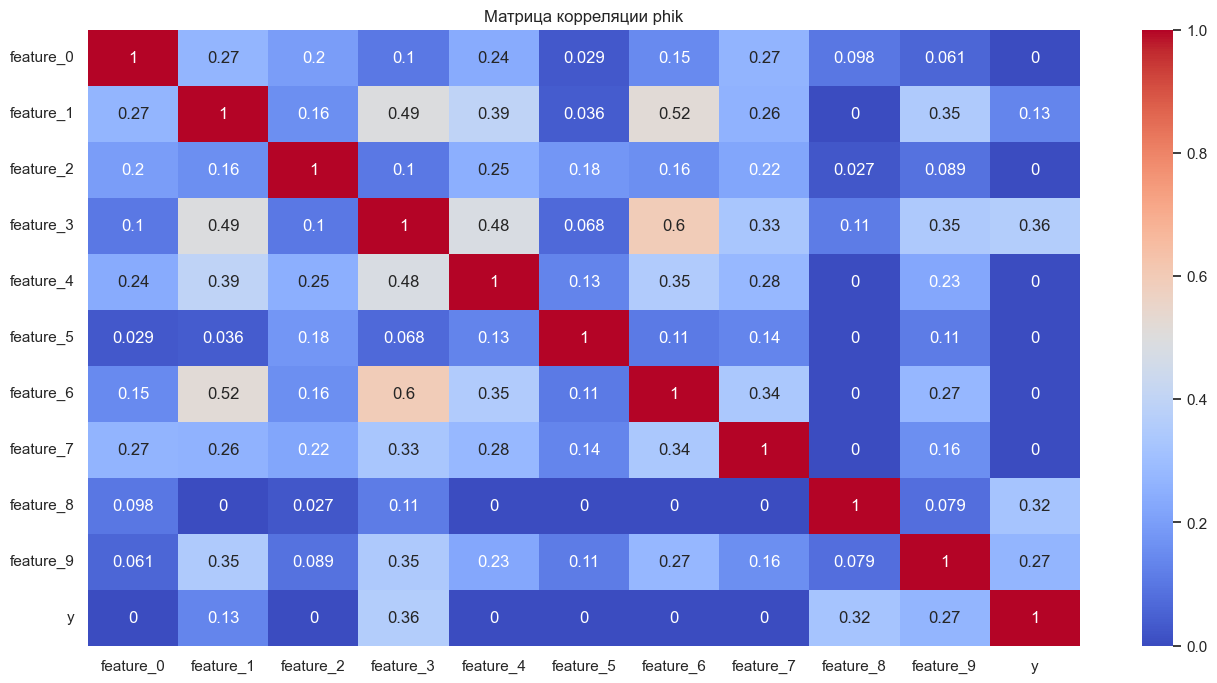

In [40]:
# применение линейного слоя для сокращения размерности
linear_reducer = LinearReducer(768, inp)  
text_features = []

for embedding in embeddings:
    with torch.no_grad():
        reduced_embedding = linear_reducer(torch.FloatTensor(embedding))
        text_features.append(reduced_embedding.numpy())
        
text_features = np.concatenate(text_features, axis=0)
text_features = pd.DataFrame(text_features, columns=[f'feature_{i}' for i in range(inp)])
text_features.to_csv('text_features_train', index=False)
text_features['y']=train['music_genre']

# связь эмбэдингов с целевым признаком
phik_overview = text_features[[col for col in text_features.columns]].phik_matrix()
plt.figure(figsize=(16, 8))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

In [36]:
text_features_train = pd.read_csv('text_features_train')

In [353]:
# применение линейного слоя для сокращения размерности
linear_reducer = LinearReducer(768, inp) 
text_features_test = []

for embedding in embeddings_test:
    with torch.no_grad():
        reduced_embedding = linear_reducer(torch.FloatTensor(embedding))
        text_features_test.append(reduced_embedding.numpy())
        
text_features_test = np.concatenate(text_features_test, axis=0)
text_features_test = pd.DataFrame(text_features_test, columns=[f'feature_{i}' for i in range(inp)])

text_features_test.to_csv('text_features_test', index=False)

In [37]:
text_features_test = pd.read_csv('text_features_test')

### Случайные математические признаки

In [38]:
# выборки
y = train['music_genre'].values
train = train.drop(['music_genre', 'track_name'], axis=1)
test = test.drop('track_name', axis=1)

In [39]:
# функция для создания новых признаков на основе математических операций
def create_math_features(data, test, features, operations):
    new_features = pd.DataFrame()
    new_features['y'] = y
    new_features_test = pd.DataFrame()
    for feature1 in features:
        for feature2 in features:
            if feature1 != feature2:
                for operation in operations:
                    if operation == 'add':
                        new_feature = data[feature1] + data[feature2]
                        new_feature_t = test[feature1] + test[feature2]
                    elif operation == 'subtract':
                        new_feature = data[feature1] - data[feature2]
                        new_feature_t = test[feature1] - test[feature2]
                    elif operation == 'multiply':
                        new_feature = data[feature1] * data[feature2]
                        new_feature_t = test[feature1] * test[feature2]
                    elif operation == 'mean':
                        new_feature = (data[feature1] + data[feature2])/2
                        new_feature_t = (test[feature1] + test[feature2])/2
                    elif operation == 'sqrt':
                        new_feature = ((data[feature1]**2 + data[feature2]**2)**0.5)/2
                        new_feature_t = ((test[feature1]**2 + test[feature2]**2)**0.5)/2
                    
                    new_feature_name = f'{feature1}_{operation}_{feature2}'
                    new_features[new_feature_name] = new_feature
                    new_features_test[new_feature_name] = new_feature_t
                    # проверка взаимосвязи с целевым признаком
                    if new_features[['y', new_feature_name]].phik_matrix().iloc()[0][1]<0.7:
                        new_features = new_features.drop(new_feature_name, axis=1)
                        new_features_test = new_features_test.drop(new_feature_name, axis=1)
    new_features = new_features.drop('y', axis=1)
    return new_features, new_features_test

# создаем новые признаки на основе заданных операций
numeric_features = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']
math_operations = ['add', 'subtract', 'multiply', 'mean', 'sgrt']  # операции
new_features, new_features_test = create_math_features(train, test, numeric_features, math_operations)

interval columns not set, guessing: ['acousticness_add_danceability']
interval columns not set, guessing: ['acousticness_subtract_danceability']
interval columns not set, guessing: ['acousticness_multiply_danceability']
interval columns not set, guessing: ['acousticness_mean_danceability']
interval columns not set, guessing: ['acousticness_sgrt_danceability']
interval columns not set, guessing: ['acousticness_add_duration_ms']
interval columns not set, guessing: ['acousticness_subtract_duration_ms']
interval columns not set, guessing: ['acousticness_multiply_duration_ms']
interval columns not set, guessing: ['acousticness_mean_duration_ms']
interval columns not set, guessing: ['acousticness_sgrt_duration_ms']
interval columns not set, guessing: ['acousticness_add_energy']
interval columns not set, guessing: ['acousticness_subtract_energy']
interval columns not set, guessing: ['acousticness_multiply_energy']
interval columns not set, guessing: ['acousticness_mean_energy']
interval colum

interval columns not set, guessing: ['energy_mean_danceability']
interval columns not set, guessing: ['energy_sgrt_danceability']
interval columns not set, guessing: ['energy_add_duration_ms']
interval columns not set, guessing: ['energy_subtract_duration_ms']
interval columns not set, guessing: ['energy_multiply_duration_ms']
interval columns not set, guessing: ['energy_mean_duration_ms']
interval columns not set, guessing: ['energy_sgrt_duration_ms']
interval columns not set, guessing: ['energy_add_instrumentalness']
interval columns not set, guessing: ['energy_subtract_instrumentalness']
interval columns not set, guessing: ['energy_multiply_instrumentalness']
interval columns not set, guessing: ['energy_mean_instrumentalness']
interval columns not set, guessing: ['energy_sgrt_instrumentalness']
interval columns not set, guessing: ['energy_add_liveness']
interval columns not set, guessing: ['energy_subtract_liveness']
interval columns not set, guessing: ['energy_multiply_liveness']
i

interval columns not set, guessing: ['loudness_multiply_duration_ms']
interval columns not set, guessing: ['loudness_mean_duration_ms']
interval columns not set, guessing: ['loudness_sgrt_duration_ms']
interval columns not set, guessing: ['loudness_add_energy']
interval columns not set, guessing: ['loudness_subtract_energy']
interval columns not set, guessing: ['loudness_multiply_energy']
interval columns not set, guessing: ['loudness_mean_energy']
interval columns not set, guessing: ['loudness_sgrt_energy']
interval columns not set, guessing: ['loudness_add_instrumentalness']
interval columns not set, guessing: ['loudness_subtract_instrumentalness']
interval columns not set, guessing: ['loudness_multiply_instrumentalness']
interval columns not set, guessing: ['loudness_mean_instrumentalness']
interval columns not set, guessing: ['loudness_sgrt_instrumentalness']
interval columns not set, guessing: ['loudness_add_liveness']
interval columns not set, guessing: ['loudness_subtract_livene

## Подготовка данных

In [66]:
# разделение на признаки  и целевую переменную тренировочных данных
X = train.reset_index(drop=True)
X =  pd.concat([X, text_features_train, new_features.reset_index(drop=True)], axis=1) 
X['len'] = pd.read_csv('data/train.csv')['track_name'].apply(lambda x: len(x))

In [67]:
# разделение на признаки  и целевую переменную тестовых данных
X_test = test.reset_index(drop=True)
X_test =  pd.concat([X_test, text_features_test, new_features_test.reset_index(drop=True)], axis=1)
X_test['len'] = pd.read_csv('data/test.csv')['track_name'].apply(lambda x: len(x))

In [68]:
# проверка размерности
X.shape, X_test.shape

((20394, 24), (5099, 24))

In [69]:
# выделение числовые, и категориальные признаки
categorical_cols = ['key', 'mode']

numerical_cols  = [i for i in X.columns.to_list() if i not in categorical_cols]

__Pipeline log__

Дополнительно логорифмируем признаки, имеющие распределение, смещенное в левую сторону

In [47]:
# числовые признаки нужно логарифмировать
log_transform_cols = ['acousticness','instrumentalness', 'liveness', 'speechiness'] 

# трансформер для логарифмирования указанных признаков
log_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=False))
])

# трансформер для стандартизации числовых признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# трансформер для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_transform_cols),
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [70]:
# стандартизация данных
X_transformed_log = preprocessor.fit_transform(X)
X_test_transformed_log = preprocessor.transform(X_test)

In [58]:
# функция для вывода результатов подбора гиперпараметров Optuna
def output_results(trial):
    print('Результаты подборы параметров:')
    print('  F1:', round(trial.value, 3))
    print('  Params: ')
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
# создаем объект StratifiedKFold для кроссвалидации
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  LogisticRegression

</div>

In [52]:
def objective(trial):
    # определение гиперпараметров для подбора
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg'])
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    
    # экземпляр модели Logistic Regression
    model = LogisticRegression(
        solver=solver,
        C=C,
        random_state=RANDOM_SEED,
        max_iter=1000,
        multi_class='multinomial'
    )
    
    # кросс-валидация
    f1_scores = []
    for train_idx, val_idx in cv.split(X_transformed_log, y):
        X_train_fold, y_train_fold = X_transformed_log[train_idx], y[train_idx]

        X_val_fold, y_val_fold = X_transformed_log[val_idx], y[val_idx]

        # обучаем модель
        model.fit(X_train_fold, y_train_fold)
        # делаем предсказания на валидационном фолде
        y_val_pred = model.predict(X_val_fold)
        # оцениваем метрику F1 Micro на валидационном фолде и добавляем в список результатов
        f1_micro = f1_score(y_val_fold, y_val_pred, average='micro')
        f1_scores.append(f1_micro)
        
    # сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)
    
    return np.mean(f1_scores)

In [56]:
# подбор гиперпараметров
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective, n_trials=10)

[I 2023-10-13 16:37:11,033] A new study created in memory with name: no-name-d3f84efc-5509-44cd-968d-1745b5f933f8
[I 2023-10-13 16:37:12,216] Trial 0 finished with value: 0.3867310827413986 and parameters: {'solver': 'sag', 'C': 0.0027552817523228204}. Best is trial 0 with value: 0.3867310827413986.
[I 2023-10-13 16:45:14,978] Trial 1 finished with value: 0.3954592170358406 and parameters: {'solver': 'newton-cg', 'C': 4.1562292505897585}. Best is trial 1 with value: 0.3954592170358406.
[I 2023-10-13 16:50:39,540] Trial 2 finished with value: 0.39604768310096417 and parameters: {'solver': 'lbfgs', 'C': 12.449958053555749}. Best is trial 2 with value: 0.39604768310096417.
[I 2023-10-13 16:52:00,792] Trial 3 finished with value: 0.38932985267536435 and parameters: {'solver': 'newton-cg', 'C': 0.010631970940004233}. Best is trial 2 with value: 0.39604768310096417.
[I 2023-10-13 16:52:17,545] Trial 4 finished with value: 0.38261235885681627 and parameters: {'solver': 'lbfgs', 'C': 0.0014691

In [59]:
# вывод результатов
trial_lr = study_lr.best_trial
best_mode_lr = trial_lr.user_attrs['best_model']
output_results(trial_lr)

Результаты подборы параметров:
  F1: 0.396
  Params: 
    solver: lbfgs
    C: 12.449958053555749


>Успешно подобраны гиперпараметры для модели на основе LogisticRegression.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.396

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  LGBMClassifier

</div>

In [76]:
def objective(trial):

    # пространство поиска гиперпараметров
    param_grid = {
            'verbosity': -1,
            'n_jobs': -1,
            'num_iterations': 1000,
            'feature_fraction': trial.suggest_float('feature_fraction', 0.01, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 105, step=10),
            'max_depth': trial.suggest_int('max_depth', 2, 16, step=2),
            'learning_rate': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True)
        }

    model = LGBMClassifier(**param_grid)
    
    # кросс-валидация
    f1_scores = []
    for train_idx, val_idx in cv.split(X_transformed_log, y):
        X_train_fold, y_train_fold = X_transformed_log[train_idx], y[train_idx]

        X_val_fold, y_val_fold = X_transformed_log[val_idx], y[val_idx]

        # обучаем модель
        model.fit(X_train_fold, y_train_fold)
        # делаем предсказания на валидационном фолде
        y_val_pred = model.predict(X_val_fold)
        # оцениваем метрику F1 Micro на валидационном фолде и добавляем в список результатов
        f1_micro = f1_score(y_val_fold, y_val_pred, average='micro')
        f1_scores.append(f1_micro)
        
    # сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)
    
    return np.mean(f1_scores)

In [77]:
# подбор гиперпараметров
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective, n_trials=20)

[I 2023-10-13 17:32:23,840] A new study created in memory with name: no-name-5f6e41f0-34e9-4e07-b3cf-be02574b1464


[LightGBM] [Warning] feature_fraction is set=0.3740097717506225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3740097717506225
[LightGBM] [Warning] feature_fraction is set=0.3740097717506225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3740097717506225
[LightGBM] [Warning] feature_fraction is set=0.3740097717506225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3740097717506225
[LightGBM] [Warning] feature_fraction is set=0.3740097717506225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3740097717506225


[I 2023-10-13 17:34:02,857] Trial 0 finished with value: 0.4622928933749654 and parameters: {'feature_fraction': 0.3740097717506225, 'min_child_samples': 45, 'max_depth': 8, 'l2_leaf_reg': 0.0027546452067407053}. Best is trial 0 with value: 0.4622928933749654.


[LightGBM] [Warning] feature_fraction is set=0.2234441464017029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2234441464017029
[LightGBM] [Warning] feature_fraction is set=0.2234441464017029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2234441464017029
[LightGBM] [Warning] feature_fraction is set=0.2234441464017029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2234441464017029
[LightGBM] [Warning] feature_fraction is set=0.2234441464017029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2234441464017029


[I 2023-10-13 17:34:11,966] Trial 1 finished with value: 0.12890898883934118 and parameters: {'feature_fraction': 0.2234441464017029, 'min_child_samples': 5, 'max_depth': 4, 'l2_leaf_reg': 6.317593736541332}. Best is trial 0 with value: 0.4622928933749654.


[LightGBM] [Warning] feature_fraction is set=0.7716548394378809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7716548394378809
[LightGBM] [Warning] feature_fraction is set=0.7716548394378809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7716548394378809
[LightGBM] [Warning] feature_fraction is set=0.7716548394378809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7716548394378809
[LightGBM] [Warning] feature_fraction is set=0.7716548394378809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7716548394378809


[I 2023-10-13 17:34:44,871] Trial 2 finished with value: 0.246989357677576 and parameters: {'feature_fraction': 0.7716548394378809, 'min_child_samples': 45, 'max_depth': 8, 'l2_leaf_reg': 0.5359213432955829}. Best is trial 0 with value: 0.4622928933749654.


[LightGBM] [Warning] feature_fraction is set=0.05958880378827197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05958880378827197
[LightGBM] [Warning] feature_fraction is set=0.05958880378827197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05958880378827197
[LightGBM] [Warning] feature_fraction is set=0.05958880378827197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05958880378827197
[LightGBM] [Warning] feature_fraction is set=0.05958880378827197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05958880378827197


[I 2023-10-13 17:34:54,243] Trial 3 finished with value: 0.12704681130793496 and parameters: {'feature_fraction': 0.05958880378827197, 'min_child_samples': 65, 'max_depth': 10, 'l2_leaf_reg': 1.452586163525853}. Best is trial 0 with value: 0.4622928933749654.


[LightGBM] [Warning] feature_fraction is set=0.04897291762873385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04897291762873385
[LightGBM] [Warning] feature_fraction is set=0.04897291762873385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04897291762873385
[LightGBM] [Warning] feature_fraction is set=0.04897291762873385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04897291762873385
[LightGBM] [Warning] feature_fraction is set=0.04897291762873385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04897291762873385


[I 2023-10-13 17:35:02,802] Trial 4 finished with value: 0.13479309168460557 and parameters: {'feature_fraction': 0.04897291762873385, 'min_child_samples': 95, 'max_depth': 10, 'l2_leaf_reg': 6.5384402987526355}. Best is trial 0 with value: 0.4622928933749654.


[LightGBM] [Warning] feature_fraction is set=0.7651473529963551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7651473529963551
[LightGBM] [Warning] feature_fraction is set=0.7651473529963551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7651473529963551
[LightGBM] [Warning] feature_fraction is set=0.7651473529963551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7651473529963551
[LightGBM] [Warning] feature_fraction is set=0.7651473529963551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7651473529963551


[I 2023-10-13 17:36:39,419] Trial 5 finished with value: 0.42154543645085835 and parameters: {'feature_fraction': 0.7651473529963551, 'min_child_samples': 75, 'max_depth': 8, 'l2_leaf_reg': 0.25171567235953834}. Best is trial 0 with value: 0.4622928933749654.


[LightGBM] [Warning] feature_fraction is set=0.5181018766813157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181018766813157
[LightGBM] [Warning] feature_fraction is set=0.5181018766813157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181018766813157
[LightGBM] [Warning] feature_fraction is set=0.5181018766813157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181018766813157
[LightGBM] [Warning] feature_fraction is set=0.5181018766813157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181018766813157


[I 2023-10-13 17:36:47,738] Trial 6 finished with value: 0.12272931615065254 and parameters: {'feature_fraction': 0.5181018766813157, 'min_child_samples': 95, 'max_depth': 14, 'l2_leaf_reg': 2.7113200314598194}. Best is trial 0 with value: 0.4622928933749654.


[LightGBM] [Warning] feature_fraction is set=0.519944135236436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519944135236436
[LightGBM] [Warning] feature_fraction is set=0.519944135236436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519944135236436
[LightGBM] [Warning] feature_fraction is set=0.519944135236436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519944135236436
[LightGBM] [Warning] feature_fraction is set=0.519944135236436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519944135236436


[I 2023-10-13 17:38:16,831] Trial 7 finished with value: 0.46317540974310845 and parameters: {'feature_fraction': 0.519944135236436, 'min_child_samples': 55, 'max_depth': 6, 'l2_leaf_reg': 0.0036040221880739866}. Best is trial 7 with value: 0.46317540974310845.


[LightGBM] [Warning] feature_fraction is set=0.7107033451333201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7107033451333201
[LightGBM] [Warning] feature_fraction is set=0.7107033451333201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7107033451333201
[LightGBM] [Warning] feature_fraction is set=0.7107033451333201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7107033451333201
[LightGBM] [Warning] feature_fraction is set=0.7107033451333201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7107033451333201


[I 2023-10-13 17:38:26,570] Trial 8 finished with value: 0.15298503902833738 and parameters: {'feature_fraction': 0.7107033451333201, 'min_child_samples': 5, 'max_depth': 12, 'l2_leaf_reg': 1.9414275524799924}. Best is trial 7 with value: 0.46317540974310845.


[LightGBM] [Warning] feature_fraction is set=0.9240741710597699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9240741710597699
[LightGBM] [Warning] feature_fraction is set=0.9240741710597699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9240741710597699
[LightGBM] [Warning] feature_fraction is set=0.9240741710597699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9240741710597699
[LightGBM] [Warning] feature_fraction is set=0.9240741710597699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9240741710597699


[I 2023-10-13 17:38:42,513] Trial 9 finished with value: 0.16402117246814368 and parameters: {'feature_fraction': 0.9240741710597699, 'min_child_samples': 35, 'max_depth': 6, 'l2_leaf_reg': 0.9712718527886567}. Best is trial 7 with value: 0.46317540974310845.


[LightGBM] [Warning] feature_fraction is set=0.519830059088022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519830059088022
[LightGBM] [Warning] feature_fraction is set=0.519830059088022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519830059088022
[LightGBM] [Warning] feature_fraction is set=0.519830059088022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519830059088022
[LightGBM] [Warning] feature_fraction is set=0.519830059088022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519830059088022


[I 2023-10-13 17:39:06,301] Trial 10 finished with value: 0.45444764090775114 and parameters: {'feature_fraction': 0.519830059088022, 'min_child_samples': 25, 'max_depth': 2, 'l2_leaf_reg': 0.01149138822596232}. Best is trial 7 with value: 0.46317540974310845.


[LightGBM] [Warning] feature_fraction is set=0.3116228440647121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3116228440647121
[LightGBM] [Warning] feature_fraction is set=0.3116228440647121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3116228440647121
[LightGBM] [Warning] feature_fraction is set=0.3116228440647121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3116228440647121
[LightGBM] [Warning] feature_fraction is set=0.3116228440647121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3116228440647121


[I 2023-10-13 17:40:57,376] Trial 11 finished with value: 0.4479258888984378 and parameters: {'feature_fraction': 0.3116228440647121, 'min_child_samples': 55, 'max_depth': 6, 'l2_leaf_reg': 0.001079688686671736}. Best is trial 7 with value: 0.46317540974310845.


[LightGBM] [Warning] feature_fraction is set=0.3835073205430317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3835073205430317
[LightGBM] [Warning] feature_fraction is set=0.3835073205430317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3835073205430317
[LightGBM] [Warning] feature_fraction is set=0.3835073205430317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3835073205430317
[LightGBM] [Warning] feature_fraction is set=0.3835073205430317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3835073205430317


[I 2023-10-13 17:41:48,367] Trial 12 finished with value: 0.4635185758236428 and parameters: {'feature_fraction': 0.3835073205430317, 'min_child_samples': 75, 'max_depth': 4, 'l2_leaf_reg': 0.017113139907878883}. Best is trial 12 with value: 0.4635185758236428.


[LightGBM] [Warning] feature_fraction is set=0.4590179913717902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4590179913717902
[LightGBM] [Warning] feature_fraction is set=0.4590179913717902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4590179913717902
[LightGBM] [Warning] feature_fraction is set=0.4590179913717902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4590179913717902
[LightGBM] [Warning] feature_fraction is set=0.4590179913717902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4590179913717902


[I 2023-10-13 17:42:04,583] Trial 13 finished with value: 0.46204751645162156 and parameters: {'feature_fraction': 0.4590179913717902, 'min_child_samples': 75, 'max_depth': 2, 'l2_leaf_reg': 0.032884151678377084}. Best is trial 12 with value: 0.4635185758236428.


[LightGBM] [Warning] feature_fraction is set=0.6078054835377442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6078054835377442
[LightGBM] [Warning] feature_fraction is set=0.6078054835377442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6078054835377442
[LightGBM] [Warning] feature_fraction is set=0.6078054835377442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6078054835377442
[LightGBM] [Warning] feature_fraction is set=0.6078054835377442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6078054835377442


[I 2023-10-13 17:42:43,452] Trial 14 finished with value: 0.46474453717530595 and parameters: {'feature_fraction': 0.6078054835377442, 'min_child_samples': 105, 'max_depth': 4, 'l2_leaf_reg': 0.011530130422548055}. Best is trial 14 with value: 0.46474453717530595.


[LightGBM] [Warning] feature_fraction is set=0.6608400492763371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608400492763371
[LightGBM] [Warning] feature_fraction is set=0.6608400492763371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608400492763371
[LightGBM] [Warning] feature_fraction is set=0.6608400492763371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608400492763371
[LightGBM] [Warning] feature_fraction is set=0.6608400492763371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608400492763371


[I 2023-10-13 17:43:18,620] Trial 15 finished with value: 0.44184544796858993 and parameters: {'feature_fraction': 0.6608400492763371, 'min_child_samples': 105, 'max_depth': 4, 'l2_leaf_reg': 0.05290941879563271}. Best is trial 14 with value: 0.46474453717530595.


[LightGBM] [Warning] feature_fraction is set=0.23479473630566206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23479473630566206
[LightGBM] [Warning] feature_fraction is set=0.23479473630566206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23479473630566206
[LightGBM] [Warning] feature_fraction is set=0.23479473630566206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23479473630566206
[LightGBM] [Warning] feature_fraction is set=0.23479473630566206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23479473630566206


[I 2023-10-13 17:45:04,821] Trial 16 finished with value: 0.44895552178286174 and parameters: {'feature_fraction': 0.23479473630566206, 'min_child_samples': 85, 'max_depth': 16, 'l2_leaf_reg': 0.018509527897369486}. Best is trial 14 with value: 0.46474453717530595.


[LightGBM] [Warning] feature_fraction is set=0.6152076756485241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6152076756485241
[LightGBM] [Warning] feature_fraction is set=0.6152076756485241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6152076756485241
[LightGBM] [Warning] feature_fraction is set=0.6152076756485241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6152076756485241
[LightGBM] [Warning] feature_fraction is set=0.6152076756485241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6152076756485241


[I 2023-10-13 17:45:44,974] Trial 17 finished with value: 0.42600722062518737 and parameters: {'feature_fraction': 0.6152076756485241, 'min_child_samples': 105, 'max_depth': 4, 'l2_leaf_reg': 0.09325624813975006}. Best is trial 14 with value: 0.46474453717530595.


[LightGBM] [Warning] feature_fraction is set=0.38621276117253134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38621276117253134
[LightGBM] [Warning] feature_fraction is set=0.38621276117253134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38621276117253134
[LightGBM] [Warning] feature_fraction is set=0.38621276117253134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38621276117253134
[LightGBM] [Warning] feature_fraction is set=0.38621276117253134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38621276117253134


[I 2023-10-13 17:46:02,790] Trial 18 finished with value: 0.44920106220105926 and parameters: {'feature_fraction': 0.38621276117253134, 'min_child_samples': 85, 'max_depth': 2, 'l2_leaf_reg': 0.008247168986602212}. Best is trial 14 with value: 0.46474453717530595.


[LightGBM] [Warning] feature_fraction is set=0.5736157163629046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5736157163629046
[LightGBM] [Warning] feature_fraction is set=0.5736157163629046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5736157163629046
[LightGBM] [Warning] feature_fraction is set=0.5736157163629046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5736157163629046
[LightGBM] [Warning] feature_fraction is set=0.5736157163629046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5736157163629046


[I 2023-10-13 17:46:47,005] Trial 19 finished with value: 0.42296760124428434 and parameters: {'feature_fraction': 0.5736157163629046, 'min_child_samples': 75, 'max_depth': 4, 'l2_leaf_reg': 0.1682373099089826}. Best is trial 14 with value: 0.46474453717530595.


In [78]:
# вывод результатов
trial_lgbm = study_lgbm.best_trial
best_mode_lgbm = trial_lgbm.user_attrs['best_model']
output_results(trial_lgbm)

Результаты подборы параметров:
  F1: 0.465
  Params: 
    feature_fraction: 0.6078054835377442
    min_child_samples: 105
    max_depth: 4
    l2_leaf_reg: 0.011530130422548055


>Успешно подобраны гиперпараметры для модели на основе LGBMClassifier.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.465

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  CatBoostClassifier

</div>

In [97]:
def objective(trial):
    # пространство поиска гиперпараметров
    param_grid = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-0, log=True),
        'depth': trial.suggest_int('depth', 2, 8, step=2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'verbose': 0,
        'random_seed': RANDOM_SEED,
        'loss_function': 'MultiClass',
        'eval_metric': 'MultiClass'  
    }

    model = CatBoostClassifier(**param_grid)

    # кросс-валидация
    f1_scores = []
    for train_idx, val_idx in cv.split(X, y):
        # разделение данных на обучающую и валидационную выборки
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # обучение модели
        train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=categorical_cols)
        val_pool = Pool(data=X_val_fold, label=y_val_fold, cat_features=categorical_cols)
        model.fit(train_pool, eval_set=val_pool)
        # метрика качества
        preds = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, preds, average='micro')
        f1_scores.append(f1)

    score = np.average(f1_scores)

    # сохранение наилучшей модели
    if trial.should_prune():
        raise optuna.TrialPruned()
    trial.set_user_attr('best_model', model)

    return score


In [82]:
# подбор гиперпараметров
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=10)

[I 2023-10-14 16:10:45,980] A new study created in memory with name: no-name-526215df-7510-4eb5-bfb6-8cc1c73e04c8
[I 2023-10-14 16:13:53,376] Trial 0 finished with value: 0.42159520620778806 and parameters: {'learning_rate': 0.6855559008982597, 'depth': 6, 'l2_leaf_reg': 0.0026289180627742117}. Best is trial 0 with value: 0.42159520620778806.
[I 2023-10-14 16:16:09,454] Trial 1 finished with value: 0.48097486364721553 and parameters: {'learning_rate': 0.20258920958126847, 'depth': 4, 'l2_leaf_reg': 5.446241568940596}. Best is trial 1 with value: 0.48097486364721553.
[I 2023-10-14 16:17:26,834] Trial 2 finished with value: 0.3152906696141391 and parameters: {'learning_rate': 3.930976032466432e-05, 'depth': 2, 'l2_leaf_reg': 0.0011858620828790155}. Best is trial 1 with value: 0.48097486364721553.
[I 2023-10-14 16:20:42,483] Trial 3 finished with value: 0.43963893104064056 and parameters: {'learning_rate': 0.00216430888382868, 'depth': 6, 'l2_leaf_reg': 0.007241331643357593}. Best is tria

In [83]:
# вывод результатов
trial_cb = study_cb.best_trial
best_mode_cb = trial_cb.user_attrs['best_model']
output_results(trial_cb)

Результаты подборы параметров:
  F1: 0.481
  Params: 
    learning_rate: 0.20258920958126847
    depth: 4
    l2_leaf_reg: 5.446241568940596


>Успешно подобраны гиперпараметры для модели на основе CatBoostClassifier.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.481

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  Нейросеть PyTorch

</div>

In [88]:
# определение архитектуры нейронной сети
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)
        
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)
        
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)
        
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)
        
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
        self.init_weights()
        
    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

__Тензор для обучения__

In [89]:
X_train_tensor = torch.tensor(X_transformed_log, dtype=torch.float32)

# создайте экземпляр LabelEncoder
label_encoder = LabelEncoder()
# преобразуйте строковые метки в числовые значения
y_encoded = label_encoder.fit_transform(y)

In [90]:
# проверяем доступность MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
def objective(trial):

    # dropout
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.5, step=0.1)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.5, step=0.1)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.5, step=0.1)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.5, step=0.1)

    # функции активации
    activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU()
                      }

    activation_1 = trial.suggest_categorical('module__activation_1', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_2 = trial.suggest_categorical('module__activation_2', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_3 = trial.suggest_categorical('module__activation_3', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_4 = trial.suggest_categorical('module__activation_4', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])

    activation_1 = activation_dict.get(activation_1)
    activation_2 = activation_dict.get(activation_2)
    activation_3 = activation_dict.get(activation_3)
    activation_4 = activation_dict.get(activation_4)


    # количество нейронов
    input_size = X_train_tensor.shape[1] 
    output_size = 10

    hidden_size_1 = trial.suggest_int('module__hidden_size_1', 5, 170,  step=5)
    hidden_size_2 = trial.suggest_int('module__hidden_size_2', 5, 170,  step=5)
    hidden_size_3 = trial.suggest_int('module__hidden_size_3', 5, 170,  step=5)
    hidden_size_4 = trial.suggest_int('module__hidden_size_4', 5, 170,  step=5)



    # скорость обучения
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-0, log=True)
    
    # размер пакета обучения
    batch_size = trial.suggest_int('batch_size', 5, 205,  step=25)
    
    # модель
    model_classifier = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)
    
    # количество шагов до остановки обучения
    patience = trial.suggest_int('patience', 10, 20,  step=10)

    # параметры подбора параметров модели
    skorch_classifier = NeuralNetClassifier(module=model_classifier,
                                            device=device,
                                            batch_size=batch_size,
                                            verbose=100,
                                            optimizer=optim.Adam,
                                            max_epochs=500,
                                            lr=lr,
                                            criterion=nn.CrossEntropyLoss,
                                            callbacks=[
                                                ('val_f1_micro', EpochScoring(scoring='f1_micro', lower_is_better=False, name='F1_micro')),
                                                ('estopper', EarlyStopping(lower_is_better=False, monitor='F1_micro', patience=patience))
                                            ])


    # кросс-валидация
    y_pred = cross_val_predict(skorch_classifier, X_train_tensor, y_encoded, cv=cv, n_jobs=-1)

    f1_micro = f1_score(y_encoded, y_pred, average='micro')
    
    return f1_micro

In [91]:
# подбор гиперпараметров
study_pyt = optuna.create_study(direction='maximize')
study_pyt.optimize(objective, n_trials=10)

[I 2023-10-14 17:00:37,103] A new study created in memory with name: no-name-39fd84e9-a560-48b6-adba-03ffe7c4c4eb


  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3686        1.9181       0.3686        1.6991  4.0346
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3788        1.9270       0.3788        1.6855  4.0444
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3697        1.9317       0.3697        1.7127  4.0522
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3671        1.9257       0.3671        1.6999  4.0582
      2      0.3846        1.7339       0.3846        1.6427  3.2427
      2      0.3923        1.7387       0.3923        1.6541  3.2327
      2      0.3782        1.7387 

     22      0.4364        1.5087       0.4364        1.5568  3.1927
     22      0.4376        1.5172       0.4376        1.5490  3.2094
     22      0.4376        1.5285       0.4376        1.5361  3.1831
     22      0.4269        1.5184       0.4269        1.5777  3.1848
     23      0.4377        1.5107       0.4377        1.5464  3.1245
     23      0.4301        1.5105       0.4301        1.5537  3.1115
     23      0.4438        1.5262       0.4438        1.5277  3.1130
     23      0.4230        1.5181       0.4230        1.5743  3.1364
     24      0.4341        1.5058       0.4341        1.5566  3.1337
     24      0.4448        1.5211       0.4448        1.5266  3.1319
     25      0.4371        1.5030       0.4371        1.5539  3.0002
     25      0.4389        1.5211       0.4389        1.5287  2.9947
     26      0.4322        1.5006       0.4322        1.5534  3.0163
     26      0.4428        1.5160       0.4428        1.5321  3.0296
     27      0.4358        1.4948 

[I 2023-10-14 17:02:21,634] Trial 0 finished with value: 0.44081592625281946 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.5, 'module__drop_3': 0.4, 'module__drop_4': 0.30000000000000004, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 115, 'module__hidden_size_2': 125, 'module__hidden_size_3': 35, 'module__hidden_size_4': 155, 'learning_rate': 0.0011615459261961887, 'batch_size': 30, 'patience': 10}. Best is trial 0 with value: 0.44081592625281946.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1402        2.2952       0.1402        2.2883  3.7121
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1402        2.2944       0.1402        2.2885  3.7042
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1402        2.2945       0.1402        2.2881  3.9354
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1402        2.2947       0.1402   

     19      0.3527        1.9188       0.3527        1.8737  3.1314
     20      0.3593        1.9087       0.3593        1.8551  3.1421
     20      0.3592        1.9031       0.3592        1.8490  3.1452
     20      0.3601        1.8995       0.3601        1.8454  3.1546
     20      0.3531        1.9114       0.3531        1.8605  3.1545
     21      0.3596        1.8906       0.3596        1.8418  3.1263
     21      0.3598        1.8999       0.3598        1.8366  3.1151
     21      0.3618        1.8956       0.3618        1.8330  3.1275
     21      0.3508        1.8919       0.3508        1.8477  3.1446
     22      0.3618        1.8897       0.3618        1.8258  3.2066
     22      0.3612        1.8847       0.3612        1.8302  3.2476
     22      0.3624        1.8789       0.3624        1.8214  3.2253
     22      0.3534        1.8893       0.3534        1.8368  3.2131
     23      0.3621        1.8797       0.3621        1.8160  3.2242
     23      0.3619        1.8748 

     40      0.3671        1.7899       0.3671        1.7385  3.0919
     41      0.3794        1.7943       0.3794        1.7224  3.1202
     41      0.3716        1.7864       0.3716        1.7271  3.1384
     41      0.3737        1.7907       0.3737        1.7280  3.1280
     41      0.3694        1.7937       0.3694        1.7354  3.1447
     42      0.3820        1.7935       0.3820        1.7197  3.1192
     42      0.3699        1.7855       0.3699        1.7240  3.1141
     42      0.3737        1.7851       0.3737        1.7254  3.1162
     42      0.3687        1.7929       0.3687        1.7330  3.0635
     43      0.3824        1.7896       0.3824        1.7166  3.0667
     43      0.3716        1.7856       0.3716        1.7216  3.0840
     43      0.3737        1.7910       0.3737        1.7232  3.0673
     43      0.3691        1.7861       0.3691        1.7304  3.0888
     44      0.3846        1.7873       0.3846        1.7142  3.0871
     44      0.3740        1.7899 

     70      0.3928        1.7417       0.3928        1.6672  3.1199
     70      0.3890        1.7326       0.3890        1.6734  3.1160
     70      0.3835        1.7354       0.3835        1.6824  3.1346
     71      0.3935        1.7336       0.3935        1.6663  3.1486
     71      0.3874        1.7289       0.3874        1.6720  3.1189
     71      0.3818        1.7267       0.3818        1.6810  3.0411
     72      0.3935        1.7321       0.3935        1.6648  3.0182
     72      0.3890        1.7297       0.3890        1.6708  3.0312
     72      0.3857        1.7314       0.3857        1.6793  3.0307
     73      0.3941        1.7304       0.3941        1.6632  3.0934
     73      0.3893        1.7262       0.3893        1.6693  3.0923
     73      0.3867        1.7358       0.3867        1.6780  3.0891
     74      0.3944        1.7200       0.3944        1.6615  3.0359
     74      0.3890        1.7250       0.3890        1.6677  3.0651
     74      0.3864        1.7286 

    103      0.4029        1.6967       0.4029        1.6302  2.9491
    103      0.3907        1.6969       0.3907        1.6488  2.9595
    104      0.4026        1.6983       0.4026        1.6299  2.9143
    104      0.3920        1.6934       0.3920        1.6476  2.8987
    105      0.4023        1.6923       0.4023        1.6287  2.9582
    105      0.3923        1.6989       0.3923        1.6473  2.9051
    106      0.4029        1.7008       0.4029        1.6282  2.9574
    106      0.3926        1.6914       0.3926        1.6464  2.9737
    107      0.4016        1.6890       0.4016        1.6270  2.9445
    107      0.3936        1.6924       0.3936        1.6455  2.9223
    108      0.4016        1.6951       0.4016        1.6263  2.9399
    108      0.3929        1.6919       0.3929        1.6450  2.9436
    109      0.4016        1.6854       0.4016        1.6255  2.9673
    109      0.3939        1.6927       0.3939        1.6442  2.9412
    110      0.4003        1.6871 

[I 2023-10-14 17:08:42,875] Trial 1 finished with value: 0.39428263214670983 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.0, 'module__drop_4': 0.5, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 170, 'module__hidden_size_2': 95, 'module__hidden_size_3': 165, 'module__hidden_size_4': 35, 'learning_rate': 9.107379072487136e-06, 'batch_size': 30, 'patience': 10}. Best is trial 0 with value: 0.44081592625281946.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3186        2.2008       0.3186        2.0133  1.4814
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2919        2.2026       0.2919        2.0215  1.5578
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3043        2.2044       0.3043        2.0090  1.6577
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------

     20      0.3958        1.7354       0.3958        1.6369  0.8575
     21      0.4010        1.7246       0.4010        1.6294  0.8237
     21      0.3949        1.7313       0.3949        1.6524  0.8268
     21      0.3929        1.7245       0.3929        1.6256  0.8432
     21      0.4036        1.7274       0.4036        1.6287  0.8504
     22      0.4026        1.7271       0.4026        1.6232  0.8279
     22      0.3962        1.7197       0.3962        1.6502  0.8051
     22      0.3923        1.7181       0.3923        1.6251  0.7825
     22      0.4033        1.7323       0.4033        1.6267  0.8009
     23      0.3974        1.7293       0.3974        1.6241  0.8358
     23      0.3959        1.7298       0.3959        1.6498  0.8707
     23      0.3956        1.7160       0.3956        1.6213  0.8708
     23      0.4046        1.7234       0.4046        1.6262  0.8585
     24      0.4039        1.7167       0.4039        1.6207  0.8273
     24      0.3933        1.7227 

[I 2023-10-14 17:09:17,527] Trial 2 finished with value: 0.4132588016083162 and parameters: {'module__drop_1': 0.5, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.5, 'module__drop_4': 0.5, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 35, 'module__hidden_size_2': 55, 'module__hidden_size_3': 145, 'module__hidden_size_4': 35, 'learning_rate': 0.000974050119133951, 'batch_size': 130, 'patience': 10}. Best is trial 0 with value: 0.44081592625281946.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3854        1.7759       0.3854        1.6642  1.0723
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3804        1.7672       0.3804        1.6690  1.0521
      2      0.3990        1.6832       0.3990        1.6663  0.7081
      2      0.3861        1.6846       0.3861        1.6695  0.7298
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4036        1.7797       0.4036        1.6502  1.2084
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  ---------

     23      0.4167        1.5394       0.4167        1.5709  0.7113
     23      0.4237        1.5368       0.4237        1.5697  0.7203
     22      0.4279        1.5537       0.4279        1.5848  0.6690
     22      0.4265        1.5489       0.4265        1.5826  0.6515
     24      0.4203        1.5381       0.4203        1.5719  0.6588
     24      0.4240        1.5301       0.4240        1.5826  0.6771
     23      0.4315        1.5471       0.4315        1.5874  0.6495
     23      0.4278        1.5415       0.4278        1.5718  0.6738
     25      0.4235        1.5334       0.4235        1.5776  0.6689
     25      0.4112        1.5300       0.4112        1.5760  0.6407
     24      0.4273        1.5376       0.4273        1.5977  0.6604
     24      0.4324        1.5405       0.4324        1.5870  0.6388
     26      0.4170        1.5332       0.4170        1.5652  0.6593
     26      0.4269        1.5274       0.4269        1.5777  0.6590
     25      0.4361        1.5372 

     51      0.4338        1.4871       0.4338        1.5804  0.6150
     50      0.4353        1.5040       0.4353        1.5715  0.6315
     52      0.4206        1.4877       0.4206        1.5703  0.6343
     52      0.4220        1.4759       0.4220        1.5983  0.6448
     51      0.4314        1.4939       0.4314        1.5932  0.6356
     53      0.4039        1.4820       0.4039        1.5724  0.6391
     53      0.4328        1.4924       0.4328        1.5801  0.6376
     52      0.4337        1.4967       0.4337        1.5685  0.6128
     54      0.4243        1.4765       0.4243        1.5821  0.6044
     53      0.4314        1.4942       0.4314        1.5797  0.6187
     55      0.4296        1.4823       0.4296        1.5810  0.6274
     54      0.4363        1.4936       0.4363        1.5862  0.6281
     56      0.4243        1.4691       0.4243        1.5856  0.6266
     55      0.4346        1.4849       0.4346        1.6156  0.6077
     57      0.4237        1.4740 

[I 2023-10-14 17:10:05,625] Trial 3 finished with value: 0.4296361675002452 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.2, 'module__drop_3': 0.1, 'module__drop_4': 0.1, 'module__activation_1': 'nn.ELU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 60, 'module__hidden_size_2': 155, 'module__hidden_size_3': 125, 'module__hidden_size_4': 145, 'learning_rate': 0.005797538980351592, 'batch_size': 155, 'patience': 20}. Best is trial 0 with value: 0.44081592625281946.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1402       15.7753       0.1402        2.2690  0.9952
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1062       11.9083       0.1062        2.2764  1.0003
      2      0.1402        5.5313       0.1402        2.2675  0.7262
      2      0.1062        2.3085       0.1062        2.2683  0.7212
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1255        9.4354       0.1255        2.2758  1.1830
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  ---------

[I 2023-10-14 17:10:28,839] Trial 4 finished with value: 0.12572325193684417 and parameters: {'module__drop_1': 0.4, 'module__drop_2': 0.4, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 110, 'module__hidden_size_2': 125, 'module__hidden_size_3': 40, 'module__hidden_size_4': 60, 'learning_rate': 0.2264897115968396, 'batch_size': 155, 'patience': 20}. Best is trial 0 with value: 0.44081592625281946.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1337        2.2990       0.1337        2.2896  0.9174
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1353        2.2991       0.1353        2.2895  0.9962
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.1291        2.2989       0.1291        2.2894  0.9967
      2      0.2138        2.2832       0.2138        2.2712  0.5127
      2      0.2141        2.2826       0.2141        2.2710  0.5170
      2      0.2222        2.2823       0.2222   

     20      0.3567        1.7772       0.3567        1.7253  0.5083
     20      0.3570        1.7753       0.3570        1.7333  0.5136
     20      0.3569        1.7777       0.3569        1.7218  0.5048
     18      0.3598        1.7926       0.3598        1.7385  0.4988
     21      0.3583        1.7768       0.3583        1.7193  0.5133
     21      0.3576        1.7769       0.3576        1.7273  0.5013
     19      0.3624        1.7869       0.3624        1.7300  0.4817
     21      0.3592        1.7737       0.3592        1.7156  0.4877
     22      0.3632        1.7632       0.3632        1.7141  0.4883
     22      0.3583        1.7681       0.3583        1.7225  0.4843
     20      0.3605        1.7773       0.3605        1.7229  0.4895
     22      0.3618        1.7716       0.3618        1.7102  0.4853
     23      0.3645        1.7674       0.3645        1.7095  0.4875
     23      0.3602        1.7586       0.3602        1.7182  0.4863
     21      0.3624        1.7778 

     41      0.3876        1.7151       0.3876        1.6589  0.4939
     42      0.3789        1.7031       0.3789        1.6623  0.5051
     42      0.3789        1.7145       0.3789        1.6755  0.4823
     40      0.3797        1.7129       0.3797        1.6650  0.5003
     42      0.3869        1.7178       0.3869        1.6582  0.5052
     43      0.3818        1.7084       0.3818        1.6608  0.4856
     43      0.3792        1.7104       0.3792        1.6741  0.5027
     41      0.3810        1.7072       0.3810        1.6634  0.4808
     43      0.3889        1.7089       0.3889        1.6561  0.4984
     44      0.3818        1.7055       0.3818        1.6594  0.5221
     44      0.3795        1.7075       0.3795        1.6727  0.5083
     42      0.3817        1.7112       0.3817        1.6615  0.5171
     44      0.3902        1.7057       0.3902        1.6542  0.5309
     45      0.3854        1.7071       0.3854        1.6578  0.4903
     45      0.3815        1.7019 

     64      0.3997        1.6835       0.3997        1.6297  0.5243
     65      0.3936        1.6715       0.3936        1.6342  0.5040
     65      0.3900        1.6869       0.3900        1.6492  0.5222
     63      0.3902        1.6810       0.3902        1.6349  0.5211
     65      0.3990        1.6832       0.3990        1.6285  0.5155
     66      0.3929        1.6725       0.3929        1.6337  0.4972
     66      0.3897        1.6784       0.3897        1.6482  0.4915
     64      0.3892        1.6795       0.3892        1.6343  0.4997
     66      0.3990        1.6835       0.3990        1.6278  0.4878
     67      0.3952        1.6759       0.3952        1.6325  0.5028
     67      0.3903        1.6714       0.3903        1.6469  0.5009
     65      0.3908        1.6808       0.3908        1.6333  0.4890
     67      0.3990        1.6791       0.3990        1.6265  0.5069
     68      0.3959        1.6733       0.3959        1.6320  0.4843
     68      0.3900        1.6729 

     88      0.4042        1.6570       0.4042        1.6111  0.5070
     89      0.4021        1.6554       0.4021        1.6168  0.4949
     89      0.3988        1.6588       0.3988        1.6324  0.4892
     87      0.4007        1.6573       0.4007        1.6164  0.5027
     89      0.4029        1.6631       0.4029        1.6098  0.4893
     90      0.4021        1.6595       0.4021        1.6164  0.5006
     90      0.3965        1.6614       0.3965        1.6319  0.5026
     88      0.4029        1.6519       0.4029        1.6156  0.4822
     90      0.4023        1.6621       0.4023        1.6094  0.4939
     91      0.4011        1.6508       0.4011        1.6156  0.5073
     91      0.3975        1.6575       0.3975        1.6312  0.5073
     89      0.4039        1.6566       0.4039        1.6149  0.5068
     91      0.4039        1.6571       0.4039        1.6089  0.5056
     92      0.4024        1.6515       0.4024        1.6151  0.4874
     92      0.3972        1.6551 

    115      0.4052        1.6473       0.4052        1.5978  0.4673
    116      0.4024        1.6349       0.4024        1.6040  0.4616
    116      0.4059        1.6464       0.4059        1.5979  0.4921
    117      0.4041        1.6359       0.4041        1.6037  0.4941
    117      0.4065        1.6435       0.4065        1.5973  0.4798
    118      0.4021        1.6324       0.4021        1.6038  0.4819
    118      0.4062        1.6447       0.4062        1.5969  0.4495
    119      0.4027        1.6356       0.4027        1.6030  0.4555
    119      0.4052        1.6452       0.4052        1.5970  0.4536
    120      0.4031        1.6283       0.4031        1.6027  0.4612
    120      0.4065        1.6384       0.4065        1.5961  0.4711
    121      0.4031        1.6306       0.4031        1.6028  0.4568
    121      0.4069        1.6437       0.4069        1.5958  0.4733
    122      0.4041        1.6298       0.4041        1.6023  0.4725
    122      0.4085        1.6429 

    175      0.4180        1.6181       0.4180        1.5795  0.4539
    176      0.4193        1.6238       0.4193        1.5795  0.4841
    177      0.4170        1.6178       0.4170        1.5792  0.4871
    178      0.4176        1.6139       0.4176        1.5788  0.4775
    179      0.4160        1.6160       0.4160        1.5787  0.4780
    180      0.4183        1.6195       0.4183        1.5784  0.4614
    181      0.4160        1.6141       0.4160        1.5790  0.4720
    182      0.4163        1.6201       0.4163        1.5791  0.4652
    183      0.4154        1.6157       0.4154        1.5783  0.4784
    184      0.4163        1.6202       0.4163        1.5773  0.4757
    185      0.4173        1.6150       0.4173        1.5774  0.4692
    186      0.4176        1.6152       0.4176        1.5773  0.4598
    187      0.4186        1.6132       0.4186        1.5768  0.4763
    188      0.4196        1.6169       0.4196        1.5771  0.4543
    189      0.4193        1.6170 

    279      0.4294        1.5900       0.4294        1.5587  0.4718
    280      0.4297        1.5926       0.4297        1.5588  0.4603
    281      0.4291        1.5885       0.4291        1.5583  0.4749
    282      0.4294        1.5950       0.4294        1.5585  0.4612
    283      0.4307        1.5898       0.4307        1.5581  0.4669
    284      0.4304        1.5858       0.4304        1.5582  0.4763
    285      0.4275        1.5963       0.4275        1.5585  0.4954
    286      0.4294        1.5913       0.4294        1.5582  0.4730
    287      0.4301        1.5895       0.4301        1.5575  0.4636
    288      0.4304        1.5858       0.4304        1.5573  0.4705
    289      0.4301        1.5836       0.4301        1.5576  0.4734
    290      0.4288        1.5964       0.4288        1.5579  0.4783
    291      0.4297        1.5874       0.4297        1.5576  0.4810
    292      0.4304        1.5937       0.4304        1.5573  0.4709
    293      0.4304        1.5864 

[I 2023-10-14 17:13:22,078] Trial 5 finished with value: 0.4137981759340983 and parameters: {'module__drop_1': 0.30000000000000004, 'module__drop_2': 0.0, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.30000000000000004, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 65, 'module__hidden_size_2': 170, 'module__hidden_size_3': 85, 'module__hidden_size_4': 155, 'learning_rate': 3.438837446395351e-05, 'batch_size': 205, 'patience': 20}. Best is trial 0 with value: 0.44081592625281946.


Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2575        2.2848       0.2575        2.2457  3.7363
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2462        2.2855       0.2462        2.2468  3.7820
Stopping since F1_micro has not improved in the last 20 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2493        2.2848       0.2493        2.2466  3.9110
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2426        2.2845       0.2426   

     19      0.3879        1.7001       0.3879        1.6584  3.1976
     19      0.3779        1.6926       0.3779        1.6750  3.1780
     20      0.3866        1.6919       0.3866        1.6471  3.1359
     20      0.3841        1.6846       0.3841        1.6504  3.1472
     20      0.3869        1.6929       0.3869        1.6545  3.1880
     20      0.3779        1.6941       0.3779        1.6719  3.2019
     21      0.3863        1.6881       0.3863        1.6418  3.1989
     21      0.3874        1.6886       0.3874        1.6468  3.1995
     21      0.3915        1.6894       0.3915        1.6506  3.2078
     21      0.3789        1.6897       0.3789        1.6667  3.1605
     22      0.3859        1.6848       0.3859        1.6390  3.1766
     22      0.3887        1.6851       0.3887        1.6430  3.1588
     22      0.3931        1.6861       0.3931        1.6464  3.1917
     22      0.3808        1.6814       0.3808        1.6633  3.2011
     23      0.3895        1.6842 

     41      0.4070        1.6333       0.4070        1.6018  3.2206
     41      0.4059        1.6418       0.4059        1.5944  3.2274
     41      0.4014        1.6358       0.4014        1.6210  3.1872
     41      0.4078        1.6388       0.4078        1.6032  3.2517
     42      0.4070        1.6282       0.4070        1.6000  3.1423
     42      0.4052        1.6345       0.4052        1.5933  3.1268
     42      0.4027        1.6323       0.4027        1.6193  3.2086
     42      0.4072        1.6392       0.4072        1.6021  3.2624
     43      0.4070        1.6340       0.4070        1.5988  3.2577
     43      0.4085        1.6407       0.4085        1.5928  3.2733
     43      0.4041        1.6321       0.4041        1.6172  3.1829
     43      0.4075        1.6328       0.4075        1.6001  3.2233
     44      0.4076        1.6283       0.4076        1.5978  3.1168
     44      0.4111        1.6379       0.4111        1.5922  3.0999
     44      0.4044        1.6325 

     63      0.4129        1.6003       0.4129        1.5949  3.2088
     63      0.4199        1.6042       0.4199        1.5779  3.2365
     64      0.4158        1.6012       0.4158        1.5778  3.1455
     64      0.4216        1.6074       0.4216        1.5683  3.1505
     64      0.4122        1.6033       0.4122        1.5943  3.1694
     64      0.4235        1.6066       0.4235        1.5773  3.1906
     65      0.4225        1.6071       0.4225        1.5685  3.1617
     65      0.4135        1.5977       0.4135        1.5766  3.1810
     65      0.4122        1.6004       0.4122        1.5936  3.1772
     65      0.4216        1.6008       0.4216        1.5762  3.2035
     66      0.4219        1.6104       0.4219        1.5674  3.1606
     66      0.4181        1.5939       0.4181        1.5765  3.1661
     66      0.4116        1.6083       0.4116        1.5925  3.1679
     66      0.4235        1.6031       0.4235        1.5744  3.1621
     67      0.4216        1.6034 

     97      0.4233        1.5722       0.4233        1.5769  3.0101
     97      0.4356        1.5726       0.4356        1.5576  3.0560
     98      0.4240        1.5722       0.4240        1.5759  3.0129
     99      0.4227        1.5645       0.4227        1.5756  3.0359
    100      0.4237        1.5717       0.4237        1.5755  3.0614
    101      0.4214        1.5746       0.4214        1.5747  3.0791


[I 2023-10-14 17:18:54,334] Trial 6 finished with value: 0.4290477591448465 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.2, 'module__drop_3': 0.5, 'module__drop_4': 0.1, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.Tanh()', 'module__hidden_size_1': 90, 'module__hidden_size_2': 145, 'module__hidden_size_3': 80, 'module__hidden_size_4': 120, 'learning_rate': 4.198480057883657e-05, 'batch_size': 30, 'patience': 10}. Best is trial 0 with value: 0.44081592625281946.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2648        2.2739       0.2648        2.2187  1.2082
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2627        2.2738       0.2627        2.2178  1.1666
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2599        2.2732       0.2599        2.2181  1.2289
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------

     19      0.3985        1.6937       0.3985        1.6391  0.6660
     19      0.3995        1.6871       0.3995        1.6270  0.6504
     19      0.4052        1.6924       0.4052        1.6177  0.6598
     19      0.4046        1.6886       0.4046        1.6263  0.6876
     20      0.4014        1.6968       0.4014        1.6352  0.6726
     20      0.4031        1.6824       0.4031        1.6250  0.6601
     20      0.4082        1.6929       0.4082        1.6137  0.6686
     20      0.4059        1.6973       0.4059        1.6238  0.6471
     21      0.3972        1.6891       0.3972        1.6334  0.6379
     21      0.4027        1.6815       0.4027        1.6221  0.6189
     21      0.4069        1.6896       0.4069        1.6123  0.6540
     21      0.4092        1.6884       0.4092        1.6218  0.6455
     22      0.3982        1.6858       0.3982        1.6297  0.6190
     22      0.4031        1.6789       0.4031        1.6188  0.6143
     22      0.4134        1.6829 

     41      0.4255        1.6511       0.4255        1.5713  0.6394
     41      0.4281        1.6427       0.4281        1.5794  0.6416
     42      0.4122        1.6331       0.4122        1.5971  0.6411
     42      0.4194        1.6332       0.4194        1.5838  0.6259
     42      0.4261        1.6393       0.4261        1.5713  0.6205
     42      0.4229        1.6348       0.4229        1.5798  0.6235
     43      0.4155        1.6372       0.4155        1.5952  0.6192
     43      0.4224        1.6246       0.4224        1.5825  0.6356
     43      0.4278        1.6461       0.4278        1.5701  0.6221
     43      0.4248        1.6420       0.4248        1.5772  0.6420
     44      0.4148        1.6346       0.4148        1.5941  0.6139
     44      0.4207        1.6275       0.4207        1.5809  0.6227
     44      0.4297        1.6438       0.4297        1.5685  0.6190
     44      0.4288        1.6352       0.4288        1.5769  0.6330
     45      0.4148        1.6297 

[I 2023-10-14 17:19:33,330] Trial 7 finished with value: 0.4288516230263803 and parameters: {'module__drop_1': 0.30000000000000004, 'module__drop_2': 0.1, 'module__drop_3': 0.0, 'module__drop_4': 0.5, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 120, 'module__hidden_size_2': 90, 'module__hidden_size_3': 130, 'module__hidden_size_4': 30, 'learning_rate': 0.00013388250294745714, 'batch_size': 155, 'patience': 10}. Best is trial 0 with value: 0.44081592625281946.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0843        2.3002       0.0843        2.2987  1.2417
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0866        2.3001       0.0866        2.2988  1.2307
      2      0.0944        2.2989       0.0944        2.2973  0.7429
      2      0.0915        2.2988       0.0915        2.2972  0.7542
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.0889        2.3003       0.0889        2.2986  1.2103
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  ---------

     19      0.1458        2.2700       0.1458        2.2674  0.7777
     21      0.1572        2.2673       0.1572        2.2630  0.7410
     21      0.1582        2.2661       0.1582        2.2627  0.7497
     20      0.1493        2.2670       0.1493        2.2644  0.7367
     20      0.1504        2.2673       0.1504        2.2652  0.7441
     22      0.1650        2.2643       0.1650        2.2607  0.7408
     22      0.1654        2.2634       0.1654        2.2603  0.7463
     21      0.1552        2.2650       0.1552        2.2621  0.7557
     21      0.1579        2.2659       0.1579        2.2629  0.7612
     23      0.1712        2.2631       0.1712        2.2583  0.7624
     23      0.1713        2.2617       0.1713        2.2579  0.7461
     22      0.1624        2.2626       0.1624        2.2596  0.7542
     22      0.1664        2.2634       0.1664        2.2605  0.7500
     24      0.1781        2.2601       0.1781        2.2558  0.7320
     24      0.1775        2.2584 

     39      0.2180        2.2138       0.2180        2.2103  0.7496
     40      0.2294        2.2092       0.2294        2.2042  0.7266
     41      0.2366        2.2108       0.2366        2.2034  0.7481
     41      0.2311        2.2089       0.2311        2.2024  0.7404
     40      0.2220        2.2116       0.2220        2.2068  0.7416
     41      0.2317        2.2063       0.2317        2.2006  0.7428
     42      0.2379        2.2080       0.2379        2.1998  0.7456
     42      0.2321        2.2064       0.2321        2.1988  0.7470
     41      0.2259        2.2083       0.2259        2.2034  0.7412
     42      0.2356        2.2027       0.2356        2.1969  0.7566
     43      0.2415        2.2041       0.2415        2.1962  0.7632
     43      0.2367        2.2015       0.2367        2.1952  0.7557
     42      0.2285        2.2045       0.2285        2.1998  0.7499
     43      0.2386        2.1993       0.2386        2.1933  0.7466
     44      0.2458        2.2018 

     59      0.2664        2.1412       0.2664        2.1359  0.7690
     60      0.2761        2.1328       0.2761        2.1264  0.7451
     61      0.2752        2.1380       0.2752        2.1266  0.7590
     61      0.2753        2.1359       0.2753        2.1258  0.7585
     60      0.2677        2.1383       0.2677        2.1320  0.7518
     61      0.2788        2.1278       0.2788        2.1224  0.7626
     62      0.2768        2.1353       0.2768        2.1226  0.7886
     62      0.2772        2.1311       0.2772        2.1219  0.7704
     61      0.2674        2.1331       0.2674        2.1282  0.7598
     62      0.2801        2.1243       0.2801        2.1184  0.7557
     63      0.2771        2.1306       0.2771        2.1186  0.7438
     63      0.2792        2.1264       0.2792        2.1180  0.7440
     62      0.2687        2.1290       0.2687        2.1243  0.7431
     63      0.2807        2.1210       0.2807        2.1144  0.7361
     64      0.2807        2.1291 

     81      0.2941        2.0558       0.2941        2.0493  0.7316
     82      0.2938        2.0644       0.2938        2.0490  0.7489
     82      0.2955        2.0584       0.2955        2.0497  0.7406
     81      0.2880        2.0617       0.2880        2.0564  0.7586
     82      0.2958        2.0539       0.2958        2.0460  0.7555
     83      0.2948        2.0618       0.2948        2.0457  0.8072
     83      0.2952        2.0563       0.2952        2.0465  0.7794
     82      0.2900        2.0577       0.2900        2.0532  0.7943
     83      0.2944        2.0492       0.2944        2.0428  0.8074
     84      0.2951        2.0603       0.2951        2.0425  0.8134
     84      0.2952        2.0524       0.2952        2.0433  0.7981
     83      0.2903        2.0552       0.2903        2.0500  0.7960
     84      0.2964        2.0463       0.2964        2.0396  0.7755
     85      0.2967        2.0554       0.2967        2.0392  0.7700
     85      0.2955        2.0487 

    101      0.3066        2.0032       0.3066        1.9961  0.7837
    103      0.3082        2.0037       0.3082        1.9845  0.7600
    103      0.3127        1.9887       0.3127        1.9829  0.7837
    103      0.3063        1.9982       0.3063        1.9869  0.7644
    102      0.3073        1.9968       0.3073        1.9932  0.7346
    104      0.3095        1.9994       0.3095        1.9817  0.7557
    104      0.3131        1.9875       0.3131        1.9801  0.7404
    104      0.3073        1.9946       0.3073        1.9841  0.7665
    103      0.3083        1.9968       0.3083        1.9904  0.7564
    105      0.3121        1.9958       0.3121        1.9788  0.7209
    105      0.3147        1.9831       0.3147        1.9772  0.7214
    105      0.3076        1.9924       0.3076        1.9813  0.7430
    104      0.3086        1.9933       0.3086        1.9875  0.7292
    106      0.3124        1.9954       0.3124        1.9760  0.7587
    106      0.3157        1.9829 

    123      0.3204        1.9454       0.3204        1.9327  0.7888
    122      0.3174        1.9482       0.3174        1.9387  0.7916
    124      0.3255        1.9355       0.3255        1.9260  0.7501
    124      0.3186        1.9474       0.3186        1.9269  0.7819
    124      0.3217        1.9425       0.3217        1.9302  0.7889
    123      0.3174        1.9454       0.3174        1.9362  0.7573
    125      0.3252        1.9354       0.3252        1.9234  0.7599
    125      0.3196        1.9451       0.3196        1.9243  0.7602
    125      0.3220        1.9403       0.3220        1.9276  0.7447
    124      0.3174        1.9423       0.3174        1.9337  0.7441
    126      0.3258        1.9317       0.3258        1.9209  0.7408
    126      0.3212        1.9444       0.3212        1.9218  0.7467
    126      0.3227        1.9378       0.3227        1.9251  0.7338
    125      0.3178        1.9389       0.3178        1.9312  0.7447
    127      0.3248        1.9261 

    145      0.3337        1.8905       0.3337        1.8765  0.7311
    145      0.3297        1.9031       0.3297        1.8764  0.7394
    145      0.3285        1.8987       0.3285        1.8804  0.7434
    144      0.3282        1.8995       0.3282        1.8875  0.7494
    146      0.3333        1.8872       0.3333        1.8744  0.7389
    146      0.3288        1.9010       0.3288        1.8743  0.7678
    146      0.3302        1.8963       0.3302        1.8783  0.7671
    145      0.3285        1.8962       0.3285        1.8854  0.7618
    147      0.3337        1.8864       0.3337        1.8723  0.7711
    147      0.3294        1.8987       0.3294        1.8721  0.7836
    147      0.3302        1.8928       0.3302        1.8761  0.7842
    146      0.3282        1.8945       0.3282        1.8834  0.7761
    148      0.3337        1.8848       0.3337        1.8703  0.7823
    148      0.3294        1.8942       0.3294        1.8699  0.7811
    148      0.3308        1.8926 

    168      0.3373        1.8488       0.3373        1.8327  0.7425
    167      0.3321        1.8577       0.3321        1.8448  0.7548
    168      0.3338        1.8587       0.3338        1.8361  0.7626
    168      0.3353        1.8591       0.3353        1.8317  0.7453
    169      0.3369        1.8471       0.3369        1.8311  0.7423
    168      0.3321        1.8554       0.3321        1.8432  0.7480
    169      0.3341        1.8546       0.3341        1.8345  0.7451
    169      0.3356        1.8616       0.3356        1.8300  0.7464
    170      0.3369        1.8481       0.3369        1.8294  0.7266
    169      0.3325        1.8575       0.3325        1.8417  0.7368
    170      0.3347        1.8551       0.3347        1.8328  0.7440
    170      0.3359        1.8562       0.3359        1.8283  0.7339
    170      0.3328        1.8573       0.3328        1.8402  0.7221
    171      0.3351        1.8522       0.3351        1.8311  0.7226
    171      0.3366        1.8551 

    212      0.3403        1.8084       0.3403        1.7889  0.7397
    213      0.3403        1.8068       0.3403        1.7880  0.7355
    214      0.3400        1.8065       0.3400        1.7871  0.7235
    215      0.3413        1.8025       0.3413        1.7862  0.7081
    216      0.3413        1.8032       0.3413        1.7853  0.7494
    217      0.3413        1.8020       0.3413        1.7845  0.7087
    218      0.3413        1.7972       0.3413        1.7837  0.7468
    219      0.3413        1.7998       0.3413        1.7828  0.7416
    220      0.3416        1.7991       0.3416        1.7819  0.7462
    221      0.3419        1.8004       0.3419        1.7811  0.7242
    222      0.3416        1.7966       0.3416        1.7803  0.7133
    223      0.3423        1.7979       0.3423        1.7795  0.7257
    224      0.3426        1.7965       0.3426        1.7787  0.7330
    225      0.3432        1.7961       0.3432        1.7780  0.7458
    226      0.3432        1.7988 

[I 2023-10-14 17:22:47,946] Trial 8 finished with value: 0.33779543002843976 and parameters: {'module__drop_1': 0.4, 'module__drop_2': 0.2, 'module__drop_3': 0.0, 'module__drop_4': 0.1, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 105, 'module__hidden_size_2': 35, 'module__hidden_size_3': 50, 'module__hidden_size_4': 95, 'learning_rate': 3.736489349302552e-06, 'batch_size': 130, 'patience': 10}. Best is trial 0 with value: 0.44081592625281946.


Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3778        1.8820       0.3778        1.6796  3.3905
Stopping since F1_micro has not improved in the last 10 epochs.
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3756        1.8781       0.3756        1.6886  3.6032
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3810        1.8813       0.3810        1.6725  3.5185
  epoch    F1_micro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3779        1.8764       0.3779        1.6783  3.5658
      2      0.3928        1.7198       0.39

     21      0.4467        1.5629       0.4467        1.5403  3.1564
     21      0.4390        1.5679       0.4390        1.5608  3.1544
     21      0.4410        1.5643       0.4410        1.5358  3.1547
     21      0.4324        1.5666       0.4324        1.5373  3.1426
     22      0.4441        1.5590       0.4441        1.5386  3.1188
     22      0.4449        1.5612       0.4449        1.5591  3.1626
     22      0.4420        1.5488       0.4420        1.5332  3.0804
     22      0.4402        1.5658       0.4402        1.5321  3.1272
     23      0.4451        1.5530       0.4451        1.5418  3.1722
     23      0.4407        1.5537       0.4407        1.5625  3.1426
     23      0.4413        1.5528       0.4413        1.5387  3.1676
     23      0.4428        1.5676       0.4428        1.5292  3.1693
     24      0.4444        1.5594       0.4444        1.5394  3.1189
     24      0.4384        1.5589       0.4384        1.5525  3.1423
     24      0.4390        1.5534 

[I 2023-10-14 17:25:42,103] Trial 9 finished with value: 0.44728841816220455 and parameters: {'module__drop_1': 0.4, 'module__drop_2': 0.5, 'module__drop_3': 0.0, 'module__drop_4': 0.4, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.Tanh()', 'module__hidden_size_1': 95, 'module__hidden_size_2': 85, 'module__hidden_size_3': 150, 'module__hidden_size_4': 70, 'learning_rate': 0.0008707754367864515, 'batch_size': 30, 'patience': 10}. Best is trial 9 with value: 0.44728841816220455.


Stopping since F1_micro has not improved in the last 10 epochs.
Stopping since F1_micro has not improved in the last 10 epochs.
Stopping since F1_micro has not improved in the last 10 epochs.
Stopping since F1_micro has not improved in the last 10 epochs.
Stopping since F1_micro has not improved in the last 10 epochs.
Stopping since F1_micro has not improved in the last 10 epochs.
Stopping since F1_micro has not improved in the last 10 epochs.


In [93]:
# вывод результатов
trial_torch = study_pyt.best_trial
output_results(trial_torch)

Результаты подборы параметров:
  F1: 0.447
  Params: 
    module__drop_1: 0.4
    module__drop_2: 0.5
    module__drop_3: 0.0
    module__drop_4: 0.4
    module__activation_1: nn.ReLU()
    module__activation_2: nn.Tanh()
    module__activation_3: nn.ReLU()
    module__activation_4: nn.Tanh()
    module__hidden_size_1: 95
    module__hidden_size_2: 85
    module__hidden_size_3: 150
    module__hidden_size_4: 70
    learning_rate: 0.0008707754367864515
    batch_size: 30
    patience: 10


>Успешно подобраны гиперпараметры для модели на основе PyTorch.
>
>Метрики качества модели, на выборке для обучения, при кроссвалидации:
>F1-micro: 0.447

## Сводная таблица качества моделей

In [99]:
data = {
    'Model': ['LogisticRegression', 'LightGBM', 'CatBoost', 'PyTorch'],
    'f1-micro': [0.396, 0.465, 0.481, 0.447]
    
}
display(pd.DataFrame(data))

,Model,f1-micro
0,LogisticRegression,0.396
1,LightGBM,0.465
2,CatBoost,0.481
3,PyTorch,0.447


>Лучшая метрика качества получина при использовании CatBoost
>
>Используем данную модель, для получения предсказаний на тестовых данных

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Определение музыкальных жанров на тестовых данных.

</div>

Используем модель с лучшей метрикой качества на тестовых данных.

In [100]:
predict = best_mode_cb.predict(X_test)

# сохранении полученных данных
testing = pd.read_csv('data/test.csv')
testing['music_genre'] = pred
testing[['instance_id', 'music_genre']].to_csv('predict.csv', index=False)

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Вывод

</div>

__Задача проекта:__ Разработка модели машинного обучения для классификации музыкальных треков по жанрам в рамках расширения сотрудничества с новыми артистами и улучшения рекомендательной системы в музыкальном стриминговом сервисе "МиФаСоль".

__Основные этапы проекта:__

__Загрузка данных:__ Начальный этап проекта включает в себя загрузку данных о музыкальных треках. Используйте файл train.csv, который содержит информацию о более чем 20,000 музыкальных треках. Эти данные будут использованы в качестве обучающих данных для модели.

__Предварительный анализ данных:__ Проведен анализ данных, включая изучение структуры данных и характеристик признаков. Оценины распределение жанров, проанализированы признаки, которые могут влиять на классификацию по жанрам.

__Подготовка данных:__ Выполните следующие шаги по подготовке данных:

- Очистка данных от пропущенных значений, аномалий и дубликатов.
- Кодирование категориальных признаков, таких как mode (мажор/минор).
- Масштабирование числовых признаков.

__Обучение модели:__ Мы разработали и обучили модель машинного обучения для классификации музыкальных треков по жанрам. Мы рассмотрели различные алгоритмы классификации и подобрали оптимальные гиперпараметры модели.

__Оценка модели:__ Наилучшие результаты показала модель градиентного бустинга CatBoost. Модель демонстрирует хорошие показатели качества с метрикой f1_micro: 0.481. Это означает, что она корректно классифицирует музыкальные треки по жанрам.

__Выводы:__

Проект успешно завершен, и была разработана модель машинного обучения для классификации музыкальных треков по жанрам. Эта модель может улучшить рекомендательную систему в музыкальном стриминговом сервисе "МиФаСоль" и помочь пользователям открывать новые артисты и жанры.

__Дальнейшая работа над проектом может включать в себя следующие улучшения:__

__Инженерия признаков:__ Разработать дополнительные признаки на основе анализа музыкальных данных, такие как анализ текстов песен или музыкальных аккордов.

__Улучшение модели:__ Попробовать различные алгоритмы машинного обучения, настраивать гиперпараметры и проводить более глубокий анализ результатов для дальнейшего улучшения модели.

__Оценка точности прогнозов:__ Провести более подробный анализ ошибок модели и исследовать, в каких случаях она может давать неправильные классификации.

Проект подчеркивает важность анализа данных, обучения моделей машинного обучения и их оценки для решения задач классификации, особенно в контексте музыкального стримингового сервиса.